In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
# import sklearn.mixture as sm
from scipy.special import logsumexp
import emcee

# import myutils
from pyia import GaiaData
import pickle

In [3]:
plt.style.use('notebook')

In [4]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [5]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [6]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [7]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [8]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<4)
iso = iso[phasecut]

In [9]:
# distance modulus
distance_app = 12.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [10]:
wangle = 180*u.deg

In [11]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p2-p1)
    return (m*(phi1.wrap_at(wangle).value - p1) + d1) * u.kpc

In [12]:
# adopt 13kpc
d0 = 13
d1 = 0
d2 = 0

cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0, d1=d1, d2=d2),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [13]:
# masks
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (((cj.phi2<-3.5*u.deg) & (cj.phi2>-4*u.deg)) | ((cj.phi2<4*u.deg) & (cj.phi2>3.5*u.deg)) &
                (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg))

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

bhb_gi_min = -0.7
bhb_gi_max = -0.2
bhb_g_min = 15.5
bhb_g_max = 16.5
bhb_mask = (g.g0-g.i0<bhb_gi_max) & (g.g0-g.i0>bhb_gi_min) & (g.g0<bhb_g_max) & (g.g0>bhb_g_min)

poly_bs = np.array([[0.2,18.9], [0.2, 19.9], [-0.25, 18.7], [-0.25,17.7]])
path_bs = mpl.path.Path(poly_bs)
bs_mask = path_bs.contains_points(points)

In [21]:
phi1_ranges0 = np.array([-3,6,15,20])*u.deg
phi1_ranges1 = np.array([2,11,20,25])*u.deg
by_fine = np.linspace(-5,5,40)
by_fine = np.linspace(-5,5,33)

In [28]:
bsize = 5*u.deg
bspace = 2*u.deg
be_left = np.arange(-5,23,bspace.value)*u.deg 
be_right = be_left + bsize
phi1_cen = 0.5 * (be_left + be_right)
Nbin = np.size(be_left)

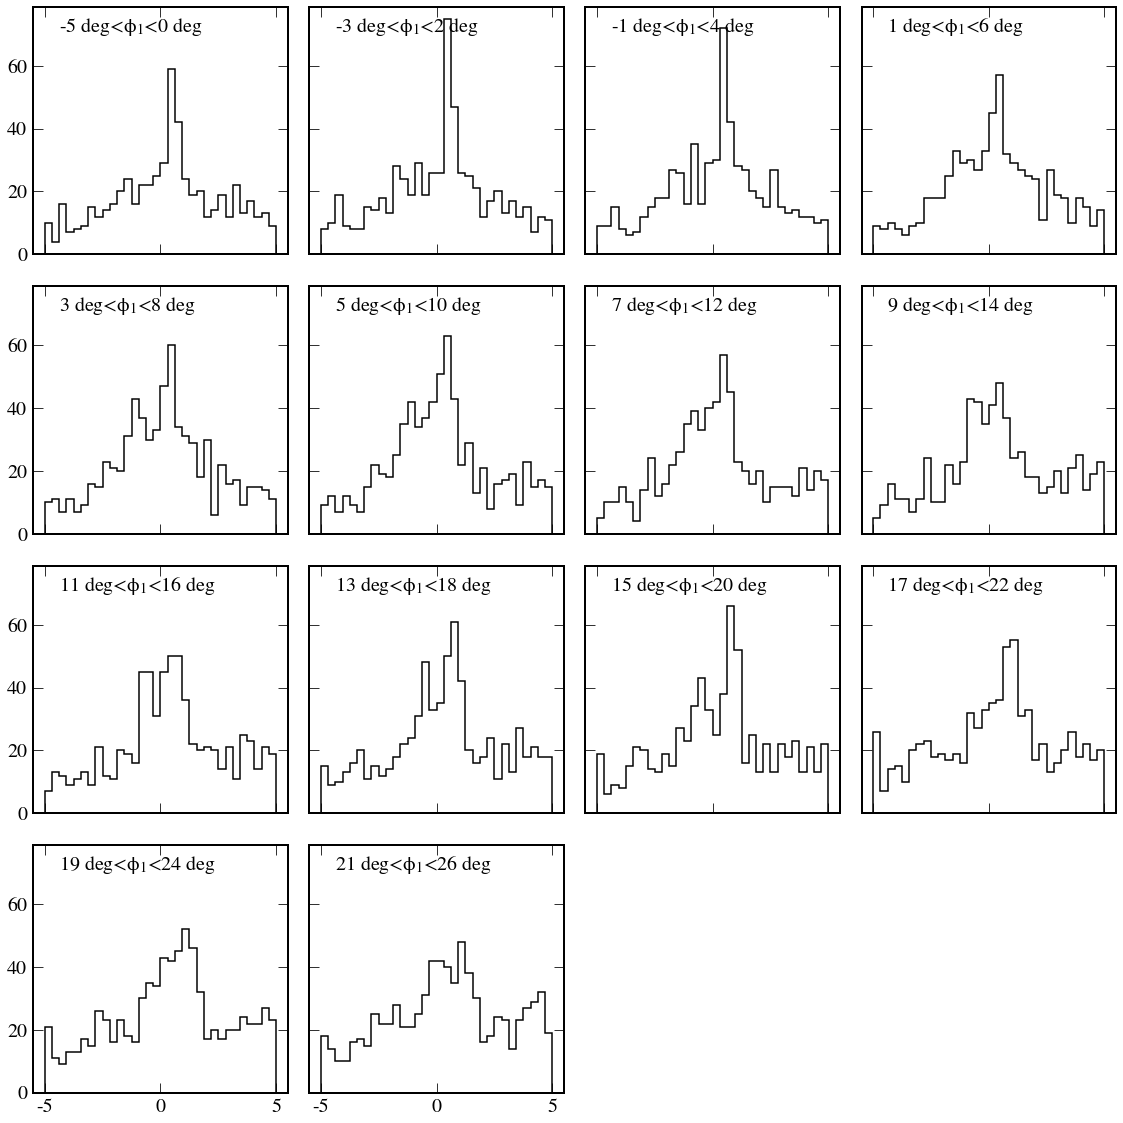

In [25]:
da = 4
nrow = 4
ncol = 4
fig, ax = plt.subplots(nrow,ncol,figsize=(ncol*da,nrow*da), sharex=True, sharey=True)

indices = []

for i in range(nrow):
    for j in range(ncol):
        plt.sca(ax[i][j])
        e = i*ncol + j
        if e<Nbin:
            ind = ((cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)>be_left[e]) & 
                   (cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)<be_right[e]))
            indices += [ind]
            
            plt.hist(cj.phi2[pm_mask & cmd_mask][ind].value, bins=by_fine, histtype='step', color='k', lw=1.5,
                density=False)

            plt.text(0.1,0.9,'{:.0f}<$\phi_1$<{:.0f}'.format(be_left[e], be_right[e]),
                    transform=plt.gca().transAxes)
        else:
            plt.axis('off')

plt.tight_layout()

In [16]:
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def lnprior(p):
    a1, a2, mu1, mu2, lnstd1, lnstd2, lnabg = p
    
    lp = 0
    
    fs = [a1, a2]
    for f in fs:
        if f < 0 or f > 1:
            return -np.inf
    
    if mu1 < mu2:
       return -np.inf
    
    if sum(fs) > 1:
        return -np.inf
    
    if mu1 < -4 or mu1 > 4 or mu2 < -4 or mu2 > 4:
        return -np.inf
    
    if (lnabg > 0) | (lnabg<-1e3):
        return -np.inf
    
    lp += lnnormal(lnstd1, -1, 5)
    lp += lnnormal(lnstd2, -1, 5)
    
    return lp

def lnlike(p, phi2):
    a1, a2, mu1, mu2, lnstd1, lnstd2, lnabg = p
    a_bg = 1 - a1 - a2
    
    component1 = lnnormal(phi2, mu1, np.exp(lnstd1))
    component2 = lnnormal(phi2, mu2, np.exp(lnstd2))
#     bg = np.full_like(component1, -np.log(5 - -5))
    bg = np.log(np.exp(lnabg) * phi2 + 1/(5 - -5)) # to normalize over phi_2 = -5 to 5
    
    return logsumexp([component1, component2, bg], b=np.array([a1, a2, a_bg])[:, None], axis=0)

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf
    
    ll = lnlike(p, phi2)
    if not np.all(np.isfinite(ll)):
        return -np.inf
    
    return ll.sum() + lp

In [18]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
bins = np.arange(-5, 5+1e-3, 0.33)

p0s = [0.07, 0.21, # a1, a2
       0.5, -0.2, # mu1, mu2, 
       np.log(0.25), np.log(1), np.log(4e-3)] #lnstd_s1, lnstd_s2,
    
phi2_grid = np.linspace(-5, 5, 256)

# plt.hist(cj.phi2[pm_mask & cmd_mask][indices[10]].to(u.deg).value, 
#          bins=bins, histtype='step', lw=1.5, normed=True, color='k')

# plt.plot(phi2_grid, np.exp(lnlike(p0s, phi2_grid)))

# plt.tight_layout()

In [27]:
best_param = np.empty((Nbin, np.size(p0s)))
med = np.empty((Nbin, np.size(p0s)))
uerr = np.empty((Nbin, np.size(p0s)))
lerr = np.empty((Nbin, np.size(p0s)))
nstar = np.empty(Nbin)

for i in range(Nbin):
    sampler = pickle.load(open('../data/chains/profile_2component_{:02d}.pkl'.format(i), 'rb'))
    idx = sampler['lnprobability'][:, -1].argmax()
    best_p = sampler['chain'][idx, -1]
    best_param[i] = best_p
#     print(best_p[:4], np.exp(best_p[4:]))
#     print(best_p)
    
    sampler['chain'][:,:,4:] = np.exp(sampler['chain'][:,:,4:])
    med[i] = np.median(sampler['chain'][:,1024:,:].reshape(-1,sampler['dim']), axis=0)
    uerr[i] = np.percentile(sampler['chain'][:,1024:,:].reshape(-1,sampler['dim']), 84, axis=0) - med[i]
    lerr[i] = med[i] - np.percentile(sampler['chain'][:,1024:,:].reshape(-1,sampler['dim']), 16, axis=0)
    nstar[i] = np.sum(indices[i])

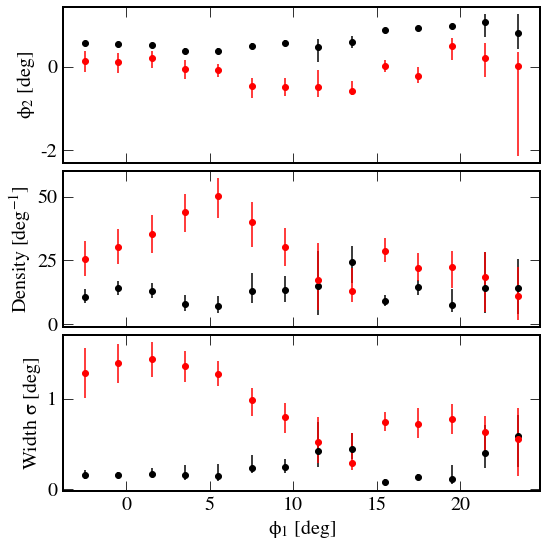

In [29]:
fig, ax = plt.subplots(3,1,figsize=(8,8), sharex=True)

plt.sca(ax[0])
plt.plot(phi1_cen, med[:,2], 'ko')
plt.errorbar(phi1_cen.value, med[:,2], yerr=(lerr[:,2], uerr[:,2]), color='k', fmt='none')
plt.plot(phi1_cen, med[:,3], 'ro')
plt.errorbar(phi1_cen.value, med[:,3], yerr=(lerr[:,3], uerr[:,3]), color='r', fmt='none')
plt.ylabel('$\phi_2$ [deg]')

plt.sca(ax[1])
plt.plot(phi1_cen, med[:,0]*nstar/bsize, 'ko')
plt.errorbar(phi1_cen.value, med[:,0]*nstar/bsize.value, yerr=(lerr[:,0], uerr[:,0])*nstar/bsize.value,
             color='k', fmt='none')
plt.plot(phi1_cen, med[:,1]*nstar/bsize, 'ro')
plt.errorbar(phi1_cen.value, med[:,1]*nstar/bsize.value, yerr=(lerr[:,1], uerr[:,1])*nstar/bsize.value,
             color='r', fmt='none')
plt.ylabel('Density [$deg^{-1}$]')

plt.sca(ax[2])
plt.plot(phi1_cen, med[:,4], 'ko')
plt.errorbar(phi1_cen.value, med[:,4], yerr=(lerr[:,4], uerr[:,4]), color='k', fmt='none')
plt.plot(phi1_cen, med[:,5], 'ro')
plt.errorbar(phi1_cen.value, med[:,5], yerr=(lerr[:,5], uerr[:,5]), color='r', fmt='none')
plt.ylabel('Width $\sigma$ [deg]')

plt.xlabel('$\phi_1$ [deg]')
plt.tight_layout(h_pad=0)
# plt.savefig('../paper/components.pdf')

## Original figure

In [34]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [35]:
# setup bins for finding track
bin_size = 3 # deg
bins = np.arange(-5, 25+bin_size, bin_size)
bincen = 0.5 * (bins[1:] + bins[:-1])

In [36]:
# median track
stream_mask = pm_mask & cmd_mask
phi2_wide_mask = stream_mask & (cj.phi2 < 1.5*u.deg) & (cj.phi2 > -0.1*u.deg)

phi2_median, be, bn = scipy.stats.binned_statistic((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       cj.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins)
phi2_sum, be = np.histogram((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

deg = 2
ptrack = np.polyfit(bincen, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-5, 25, 100)
phi2_ = polytrack(phi1_)

In [37]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
narrow_mask = phi1_mask & (np.abs(cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg)<=0.4*u.deg)
wide_mask = (phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<-0.4*u.deg)
             & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>-2.*u.deg))

In [78]:
# set up running median bins, arrays
bin_size = 3 # deg
bin_width = 4
bin_l = np.arange(-5, (25-bin_size)+1, bin_size)
bin_r = bin_l + bin_width
bins_phi1 = 0.5 * (bin_l+bin_r)

all_mask = np.ones_like(narrow_mask, dtype=bool)
masks = [all_mask, narrow_mask, wide_mask]

Nbins = len(bin_l)
rmed_n = np.zeros((3,Nbin))
rmed_phi2 = np.zeros((3,Nbin))*u.deg
rmed_phi2_err = np.zeros((3,Nbin))*u.deg
rmed_pmphi1 = np.zeros((3,Nbin))*u.mas/u.yr
rmed_pmphi2 = np.zeros((3,Nbin))*u.mas/u.yr
rmed_pmphi1_err = np.zeros((3,Nbin))*u.mas/u.yr
rmed_pmphi2_err = np.zeros((3,Nbin))*u.mas/u.yr

In [79]:
# stream track properties
phi2_poly = polytrack(cj.phi1.wrap_at(180*u.deg))
off_phi2 = 3
delta_phi2 = 1.5
_phi1 = cj.phi1.wrap_at(180*u.deg).degree

for e in range(3):
    for i, l, r in zip(range(Nbin), be_left, be_right):
        sel_bin = (_phi1 > l.value) & (_phi1 <= r.value)
        sel_stream = (np.abs(cj.phi2.to(u.deg).value - phi2_poly) < delta_phi2)
#         sel_stream = (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly) < delta_phi2)
#         sel_back = ((np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
#                     (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
        selection = sel_bin & sel_stream & masks[e] & pm_mask & cmd_mask
        rmed_n[e][i] = np.sum(selection)

        rmed_phi2[e][i] = np.nanmedian(cj.phi2[selection])
        rmed_phi2_err[e][i] = mad_std(cj.phi2[selection])

        rmed_pmphi1[e][i] = np.nanmedian(cj_dist.pm_phi1_cosphi2[selection])
        rmed_pmphi1_err[e][i] = mad_std(cj_dist.pm_phi1_cosphi2[selection])

        rmed_pmphi2[e][i] = np.nanmedian(cj_dist.pm_phi2[selection])
        rmed_pmphi2_err[e][i] = mad_std(cj_dist.pm_phi2[selection])

In [80]:
rmed_n_ = rmed_n - np.min(rmed_n, axis=1)[:,np.newaxis]
rmed_norm = rmed_n_ / np.max(rmed_n_, axis=1)[:,np.newaxis]
print(rmed_norm)

[[0.         0.32989691 0.45360825 0.56701031 0.71134021 0.78350515
  0.56701031 0.5257732  0.8556701  0.7628866  0.65979381 0.75257732
  1.         0.70103093]
 [0.5        0.94642857 0.82142857 0.57142857 0.80357143 1.
  0.83928571 0.53571429 0.78571429 0.98214286 0.98214286 0.69642857
  0.53571429 0.        ]
 [0.05454545 0.         0.14545455 0.41818182 0.49090909 0.8
  0.74545455 0.85454545 1.         0.8        0.54545455 0.52727273
  0.94545455 0.38181818]]


In [45]:
import gala.dynamics as gd
import gala.potential as gp

ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

pos = np.load('../data/jhelum_orbit_narrow.npy')
# pos = np.load('../data/jhelum_orbit.npy')

phi1, phi2, d, pm1, pm2, vr = pos

c_ = Jhelum(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, 
           pm_phi1_cosphi2=pm1*u.mas/u.yr,
           pm_phi2=pm2*u.mas/u.yr,
           radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c_.transform_to(gc_frame).cartesian)

dt = 0.5*u.Myr
fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=42)
model_jhelum_nocorr = fit_orbit.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

In [46]:
# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = model_jhelum_nocorr.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
model_jhelum = coord.Galactic(rep).transform_to(Jhelum)

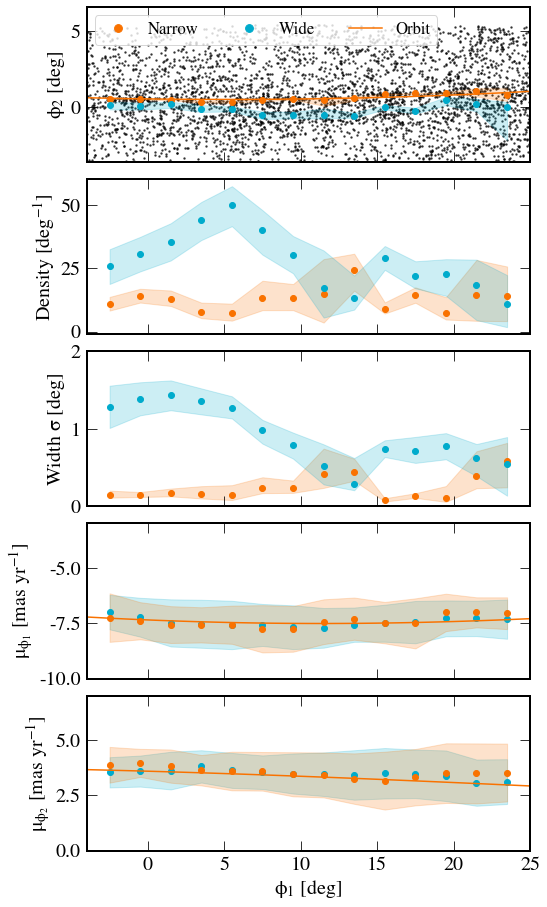

In [92]:
fig, ax = plt.subplots(5,1,figsize=(8,13), sharex=True, subplot_kw={'adjustable':'datalim'})

# cmaps = ['OrRd', 'GnBu']
# colors = ['tab:red', 'tab:blue', 'salmon']
colors = ['', '#00abcc', '#f97200']
meds = [rmed_phi2, rmed_pmphi1, rmed_pmphi2]
errs = [rmed_phi2_err, rmed_pmphi1_err, rmed_pmphi2_err]
labels = ['Narrow', 'Wide']

for e in range(2):
    for k, ka in enumerate([3,4]):
        plt.sca(ax[ka])
        k += 1
        if k>0:
            plt.fill_between(phi1_cen.value, meds[k][e+1] - errs[k][e+1], meds[k][e+1] + errs[k][e+1],
                            color=colors[e+1], alpha=0.2, label='', zorder=0)
        
        plt.plot(phi1_cen.value, meds[k][e+1], 'o', color=colors[e+1])

plt.sca(ax[0])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=3, alpha=0.6, zorder=0,
        label='')

plt.fill_between(phi1_cen.value, med[:,2]-lerr[:,2], med[:,2]+uerr[:,2], color=colors[2], alpha=0.2, label='')
plt.plot(phi1_cen, med[:,2], 'o', color=colors[2], label='Narrow')
plt.fill_between(phi1_cen.value, med[:,3]-lerr[:,3], med[:,3]+uerr[:,3], color=colors[1], alpha=0.2, label='')
plt.plot(phi1_cen, med[:,3], 'o', color=colors[1], label='Wide')

plt.plot(model_jhelum_nocorr.phi1.wrap_at(wangle), model_jhelum_nocorr.phi2, '-', color=colors[2],
         label='Orbit')

plt.ylabel('$\phi_2$ [deg]')
plt.ylim(-3,6)
plt.xlim(-4,25)
plt.gca().set_aspect('equal')

# reorder legend entries
handles, labels = plt.gca().get_legend_handles_labels()
# legend_order = np.array([1,2,0], dtype=np.int)
# handles = [handles[x] for x in legend_order]
# labels = [labels[x] for x in legend_order]
plt.legend(handles, labels, loc=2, fontsize='small', ncol=3, markerscale=1.3)

plt.sca(ax[1])
plt.fill_between(phi1_cen.value, (med[:,0]-lerr[:,0])*nstar/bsize.value, (med[:,0]+uerr[:,0])*nstar/bsize.value,
             color=colors[2], alpha=0.2)
plt.plot(phi1_cen, med[:,0]*nstar/bsize, 'o', color=colors[2])
plt.fill_between(phi1_cen.value, (med[:,1]-lerr[:,1])*nstar/bsize.value, (med[:,1]+uerr[:,1])*nstar/bsize.value,
             color=colors[1], alpha=0.2)
plt.plot(phi1_cen, med[:,1]*nstar/bsize, 'o', color=colors[1])
plt.ylabel('Density [$deg^{-1}$]')

plt.sca(ax[2])
plt.fill_between(phi1_cen.value, med[:,4]-lerr[:,4], med[:,4]+uerr[:,4], color=colors[2], alpha=0.2)
plt.plot(phi1_cen, med[:,4], 'o', color=colors[2])
plt.ylim(0,60)

plt.fill_between(phi1_cen.value, med[:,5]-lerr[:,5], med[:,5]+uerr[:,5], color=colors[1], alpha=0.2)
plt.plot(phi1_cen, med[:,5], 'o', color=colors[1])
plt.ylabel('Width $\sigma$ [deg]')
plt.ylim(0,2)

plt.sca(ax[3])
plt.plot(model_jhelum_nocorr.phi1.wrap_at(wangle), model_jhelum_nocorr.pm_phi1_cosphi2.to(u.mas/u.yr), '-',
        color=colors[2],)

plt.ylim(-10,-3)
plt.ylabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')

plt.sca(ax[4])
plt.plot(model_jhelum_nocorr.phi1.wrap_at(wangle), model_jhelum_nocorr.pm_phi2.to(u.mas/u.yr), '-',
         color=colors[2],)

plt.ylim(0,7)
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
    
plt.tight_layout(h_pad=0.1)
plt.savefig('../paper/components.pdf')